In [1]:
import numpy as np

# Find indices of the different peaks in the data
def findPeakIndices(data):
    n = int(round(sum(data[:,1] == 0)/2)+1)
    indices = np.zeros([n,2], dtype="uint32")
    a = False
    ii = 0
    for i in range(len(data[:,1])-1):
        if data[i,1] == 0 and a:
            indices[ii, 1] = i - 1
            if ii != n:
                indices[ii+1, 0] = i
            ii += 1
        a = data[i,1] == 0
    last = n-sum(indices[:,0]>=indices[:,1])
    indices = indices[0:last+1,:]
    indices[last, 1] = len(data[:,0]) - 1
    return indices

In [2]:
from scipy.optimize import leastsq
import numpy as np

# Get one mean by fitting a Gaussian distribution to the data
# with resolution of 280000
def getMean(peak):
    mu = np.average(peak[:,0], weights=peak[:,1])
    sigma = mu/(280000*2*np.sqrt(2*np.log(2)))
    fitfunc  = lambda p, x: p[0]*np.exp(-0.5*((x-p[1])/sigma)**2)
    errfunc  = lambda p, x, y: (y - fitfunc(p, x))
    init  = [1.0, mu]
    out = leastsq(errfunc, init, args=(peak[:,0], peak[:,1]))
    c = out[0]
    return c

In [19]:
from scipy.optimize import minimize
import numpy as np
import scipy.signal as scs

# Calculate mean square error for the model
def MSE(x, y, a, mu, sigma):
    norm = lambda a, mu, x: a*np.exp(-0.5*((x-mu)/sigma)**2)
    error = 0
    for i in range(len(y)):
        error = error + (y[i] - np.sum(norm(a,mu,x[i])))**2
    return error/len(y)

def errorFunction(x, y, sigma):
    return lambda params: MSE(x, y, params[::2], params[1::2], sigma)

# Function used to group values that are too close (abs(mu[n]-mu[n+1])<th) to each other together
def group(mu, th):
    groups = []
    unassigned = np.linspace(0,len(mu)-1,len(mu)).astype(int)
    while len(unassigned) > 0:
        dist = abs(np.array(mu[unassigned]) - mu[unassigned[0]])
        group = unassigned[dist < th]
        unassigned = unassigned[dist >= th]
        groups += [group]
    return groups



# Get one or more means depending on if there are multiple peaks in the data
# by fitting one or more Gaussian distributions to the data using resolution of 280000 
def getMeans(peaks):
    ind = scs.find_peaks(peaks[:,1], max(peaks[:,1])/20, prominence=max(peaks[:,1])/10)[0]
    mu = peaks[ind,0]
    n = len(mu)
    sigma = mu/(280000*2*np.sqrt(2*np.log(2)))
    
    init  = []
    for i in range(len(mu)):
        init += [np.mean(peaks[:,1]), mu[i]]
    
    # Fit n Gaussian distributions to the data
    f = errorFunction(peaks[:,0], peaks[:,1], sigma)
    params = minimize(f, init, method='BFGS').x
    
    a = params[::2]
    mu = params[1::2]
    
    # Group fitted distributions that are too close to each other together
    # and combine them
    groups = group(mu, 1e-5)
    a2 = np.zeros(len(groups))
    mu2 = np.zeros(len(groups))
    sigma2 = np.zeros(len(groups))
    for i in range(len(groups)):
        mu2[i] = np.mean(mu[groups[i]])
        a2[i] = np.sum(a[groups[i]])
        sigma2[i] = np.mean(sigma[groups[i]])
    return mu2, a2, sigma2

In [7]:
import numpy as np

# Get all peak means for the data
def getAllMeans(peaks):
    indices = findPeakIndices(peaks)
    n = len(indices[:,0])
    means = []
    aa = []
    sigmas = []
    peaki = []
    for i in range(n):
        peak = peaks[indices[i,0]:indices[i,1]+1,:]
        mu, a, sigma = getMeans(peak)
        for ii in range(len(a)):
            means += [mu[ii]]
            aa += [a[ii]]
            sigmas += [sigma[ii]]
            peaki += [i]
    return means, aa, sigmas, peaki

In [8]:
import pandas as pd
import numpy as np

# Identify peaks and return a data frame of peaks and their properties
def identifyPeaks(data, peaklist, th):
    peaklist['observed'] = np.zeros(len(peaklist['mz']))
    peaklist['a'] = np.zeros(len(peaklist['mz']))
    peaklist['sigma'] = np.zeros(len(peaklist['mz']))
    peaklist['peak'] = np.zeros(len(peaklist['mz']))
    peakMeans, a, sigmas, ind = getAllMeans(data)
    trueValue = peaklist['mz'].to_numpy()
    for i in range(len(trueValue)):
        if min(abs(peakMeans - trueValue[i])) < th:
            j = np.argmin(abs(peakMeans - trueValue[i]))
            peaklist.iloc[i,2] = peakMeans[j]
            peaklist.iloc[i,3] = a[j]
            peaklist.iloc[i,4] = sigmas[j]
            peaklist.iloc[i,5] = ind[j]
    unidentified = np.linspace(0, len(trueValue)-1, len(trueValue))
    unidentified = unidentified[peaklist['observed'].to_numpy() == 0]
    return peaklist.drop(unidentified)

In [9]:
# Calculate intensity from a and sigma values that you can find from the identifyPeaks() data  frame
def getIntensity(a, sigma):
    return a/sigma*np.sqrt(2*np.pi)

# Calculate logarithm of intensity from a and sigma values that you can find from the identifyPeaks() data  frame
def getLogIntensity(a, sigma):
    return np.log(a) - np.log(sigma) + 0.5*np.log(2*np.pi)

In [10]:
import numpy as np
import pandas as pd

# Read a file in the correct format for these functions
def readFile(fileName):
    return pd.read_csv(fileName).iloc[3:,:2].to_numpy().astype("float64")

In [22]:
from os import listdir
from os.path import isfile, join
from IPython.display import clear_output

# Process all files from path
def getPeaklists(path, th=1e-4, pl="peaklist.csv"):
    files = [f for f in listdir(path) if isfile(join(path, f))]
    plist = pd.read_csv(pl)
    peaklists = [None]*len(files)
    for i in range(len(files)):
        peaklists[i] = identifyPeaks(readFile(join(path, files[i])), plist, th)
        clear_output(wait=True)
        print(str(i+1) + "/" + str(len(files)) + " files processed.")
    return peaklists

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plt.rcParams['figure.figsize'] = [12, 10]

# Plot a peak i from a peaklist that's fram data
def plotPeak(i, peaklist, data):
    if i < len(peaklist.iloc[:,0]):
        peakindex = findPeakIndices(data)
        ii = int(peaklist.iloc[i,5])
        peak = data[peakindex[ii,0]:peakindex[ii,1]+1]
        plt.plot(peak[:,0],peak[:,1])
        middle = round(len(peak[:,0])/2)
        x = np.linspace(peak[0,0],peak[-1,0],1000)
        y = peaklist.iloc[i,3]*np.exp(-0.5*((x-peaklist.iloc[i,2])/peaklist.iloc[i,4])**2)
        plt.plot(x,y)
        plt.vlines(peaklist.iloc[i,2],0,max(peak[:,1]))
        plt.vlines(peaklist.iloc[i,1],0,max(peak[:,1]), color = "green")
        plt.legend(["Data","Fitted normal distribution","Mean from data","True mean"])
        plt.title(peaklist.iloc[i,0])
        plt.show()

In [62]:
# Choose n peaks with the smallest error
def selectPeaksMinimumError(peaks, n):
    errors = abs(peaks.iloc[:,1]-peaks.iloc[:,2])
    ind = np.argpartition(errors, n)
    return peaks.iloc[ind[:n],:], peaks.iloc[ind[n:],:]

# Choose n peaks with error closest to the mean error
def selectPeaksMeanError(peaks, n):
    errors = abs(peaks.iloc[:,1]-peaks.iloc[:,2])
    ind = np.argpartition(abs(errors-np.mean(errors)), n)
    return peaks.iloc[ind[:n],:], peaks.iloc[ind[n:],:]

# Choose n peaks with error closest to the median error
def selectPeaksMedianError(peaks, n):
    errors = abs(peaks.iloc[:,1]-peaks.iloc[:,2])
    ind = np.argpartition(abs(errors-np.median(errors)), n)
    return peaks.iloc[ind[:n],:], peaks.iloc[ind[n:],:]

# Choose n peaks with the highest intensity
def selectPeaksHighestIntensity(peaks, n):
    intensity = getLogIntensity(peaks.iloc[:, 3], peaks.iloc[:, 4])
    ind = np.argpartition(-1*intensity, n)
    return peaks.iloc[ind[:n],:], peaks.iloc[ind[n:],:]


# Splits the peaks into k partitions and selects n peaks from each partition
# so it results in n*k peaks for training and the rest of the peaks for testing
def selectPeaks(peaklist, n, k, select=selectPeaksMinimumError):
    n_peaks = len(peaklist.iloc[:,0])
    partition_size = int((n_peaks - (n_peaks % k)) / k)
    test = pd.DataFrame(columns=["formula","mz","observed","a","sigma","peak"])
    train = pd.DataFrame(columns=["formula","mz","observed","a","sigma","peak"])
    for i in range(k):
        if i < k-1:
            partition = peaklist.iloc[i*partition_size:(i+1)*partition_size,:]
        else:
            partition = peaklist.iloc[i*partition_size:,:]
        tr, ts = select(partition, n)
        test = test.append(ts)
        train = train.append(tr)
    return train, test

In [14]:
def combineObservations(peaklists):
    peaklist = peaklists[0][["formula", "mz", "observed"]].set_index("formula")
    for i in range(len(peaklists)-1):
        peaklist = peaklist.join(peaklists[i+1][["formula", "observed"]].set_index("formula"), on="formula", rsuffix='_'+str(i+1))
    return peaklist

def combinePeaklists(peaklists):
    peaklist = peaklists[0].set_index("formula")
    for i in range(len(peaklists)-1):
        peaklist = peaklist.join(peaklists[i+1].drop("mz", axis=1).set_index("formula"), on="formula", rsuffix='_'+str(i+1))
    return peaklist

In [150]:
from scipy.optimize import curve_fit

# Polynomial fit using 4 different peak selection methods
# Degree has to be 1-5
def fitPolynomialAll(pl, degree=3, n=3, k=5, q=0.6, plot=True, printErrors=True):
    train, test = selectPeaks(pl, n, k, selectPeaksMedianError)
    train2, test2 = selectPeaks(pl, n, k, selectPeaksMinimumError)
    train3, test3 = selectPeaks(pl, n, k, selectPeaksHighestIntensity)
    
    test = pl[pl["mz"].isin(set(test["mz"]).intersection(set(test2["mz"])))]
    
    train_x = train["observed"]
    train_y = train["mz"]
    train2_x = train2["observed"]
    train2_y = train2["mz"]
    train3_x = train3["observed"]
    train3_y = train3["mz"]
    train_logint = np.mean(getLogIntensity(train["a"], train["sigma"]))
    test_x = test["observed"]
    test_y = test["mz"]
    test3_x = test3["observed"]
    test3_y = test3["mz"]
    test_logint = getLogIntensity(test["a"], test["sigma"])

    functions = [lambda x, a: a, 
        lambda x, a, b: a + b*x, 
        lambda x, a, b, c: a + b*x + c*x**2, 
        lambda x, a, b, c, d: a + b*x + c*x**2 + d*x**3, 
        lambda x, a, b, c, d, e: a + b*x + c*x**2 + d*x**3 + e*x**4]
    f = functions[degree-1]

    p = curve_fit(f, train_x, train_x-train_y)[0]
    p2 = curve_fit(f, train2_x, train2_x-train2_y)[0]
    p3 = curve_fit(f, train3_x, train3_x-train3_y)[0]

    if 5 - degree > 0:
        p0 = np.zeros(5)
        p0[0:degree] = p
        p = p0
        p0 = np.zeros(5)
        p0[0:degree] = p2
        p2 = p0
        p0 = np.zeros(5)
        p0[0:degree] = p3
        p3 = p0
    f = functions[4]
    fit = f(test_x, p[0], p[1], p[2], p[3], p[4])
    fit2 = (q*f(test_x, p[0], p[1], p[2], p[3], p[4]) + (1.0-q)*f(test_x, p2[0], p2[1], p2[2], p2[3], p2[4]))
    fit3 = f(test_x, p2[0], p2[1], p2[2], p2[3], p2[4])
    fit4 = f(test3_x, p3[0], p3[1], p3[2], p3[3], p3[4])

    if plot:
        plt.scatter(test_x, test_x-test_y)
        x_coor = np.linspace(min(test_x), max(test_x), 1000)
        plt.plot(x_coor, f(x_coor, p[0], p[1], p[2], p[3], p[4]))
        plt.plot(x_coor, f(x_coor, p2[0], p2[1], p2[2], p2[3], p2[4]))
        plt.plot(x_coor, (q*f(x_coor, p[0], p[1], p[2], p[3], p[4]) + (1.0-q)*f(x_coor, p2[0], p2[1], p2[2], p2[3], p2[4])))
        plt.plot(x_coor, f(x_coor, p3[0], p3[1], p3[2], p3[3], p3[4]))
        plt.legend(["Median error", "Minimum error", "Median + Minimum error", "Highest intensity"])
        plt.show()
    
    err1 = sum((test_x-test_y - fit)**2)/sum((test_x-test_y)**2)
    err2 = sum((test_x-test_y - fit3)**2)/sum((test_x-test_y)**2)
    err3 = sum((test_x-test_y - fit2)**2)/sum((test_x-test_y)**2)
    err4 = sum((test3_x-test3_y - fit4)**2)/sum((test3_x-test3_y)**2)
    if printErrors:
        print("Median error:")
        print(str(round(err1*10000)/100)+"% of the prefit MSE")
        print()
        print("Minimum error:")
        print(str(round(err2*10000)/100)+"% of the prefit MSE")
        print()
        print("Median + Minimum error:")
        print(str(round(err3*10000)/100)+"% of the prefit MSE")
        print()
        print("Highest intensity:")
        print(str(round(err4*10000)/100)+"% of the prefit MSE")
    
    return p, p2, np.array([err1, err2, err3, err4])

In [151]:
from scipy.optimize import curve_fit

# Polynomial fit using one selection method, returns parameters for the model and the error
# Degree has to be 1-5
def fitPolynomial(pl, degree=3, selection=selectPeaksMinimumError, n=3, k=5, q=0.6, plot=True, printErrors=True):
    train, test = selectPeaks(pl, n, k, selection)

    train_x = train["observed"]
    train_y = train["mz"]
    test_x = test["observed"]
    test_y = test["mz"]

    functions = [lambda x, a: a, 
        lambda x, a, b: a + b*x, 
        lambda x, a, b, c: a + b*x + c*x**2, 
        lambda x, a, b, c, d: a + b*x + c*x**2 + d*x**3, 
        lambda x, a, b, c, d, e: a + b*x + c*x**2 + d*x**3 + e*x**4]
    f = functions[degree-1]

    p = curve_fit(f, train_x, train_x-train_y)[0]

    if 5 - degree > 0:
        p0 = np.zeros(5)
        p0[0:degree] = p
        p = p0

    f = functions[4]
    fit = f(test_x, p[0], p[1], p[2], p[3], p[4])

    if plot:
        plt.scatter(train_x, train_x-train_y)
        plt.scatter(test_x, test_x-test_y)
        x_coor = np.linspace(min(test_x), max(test_x), 1000)
        plt.plot(x_coor, f(x_coor, p[0], p[1], p[2], p[3], p[4]))
        plt.legend(["training data", "test data", "model"])
        plt.show()
    
    err = sum((test_x-test_y - fit)**2)/sum((test_x-test_y)**2)

    if printErrors:
        print(str(round(err*10000)/100)+"% of the prefit MSE")

    
    return p, err

In [152]:
from scipy.optimize import curve_fit

# Polynomial fit using a combination of 2 peak selection methods
# q*f_selection1(x) + (1-q)*f_selection2(x)
# Returns the parameters for both functions with the error
# Degree has to be 1-5
def fitPolynomial2(pl, degree=3, selection1=selectPeaksMinimumError, selection2=selectPeaksMedianError, n=3, k=5, q=0.5, plot=True, printErrors=True):
    train, test = selectPeaks(pl, n, k, selection1)
    train2, test2 = selectPeaks(pl, n, k, selection2)
    
    test = pl[pl["mz"].isin(set(test["mz"]).intersection(set(test2["mz"])))]
    
    train_x = train["observed"]
    train_y = train["mz"]
    train2_x = train2["observed"]
    train2_y = train2["mz"]
    test_x = test["observed"]
    test_y = test["mz"]

    functions = [lambda x, a: a, 
        lambda x, a, b: a + b*x, 
        lambda x, a, b, c: a + b*x + c*x**2, 
        lambda x, a, b, c, d: a + b*x + c*x**2 + d*x**3, 
        lambda x, a, b, c, d, e: a + b*x + c*x**2 + d*x**3 + e*x**4]
    f = functions[degree-1]

    p = curve_fit(f, train_x, train_x-train_y)[0]
    p2 = curve_fit(f, train2_x, train2_x-train2_y)[0]

    if 5 - degree > 0:
        p0 = np.zeros(5)
        p0[0:degree] = p
        p = p0
        p0 = np.zeros(5)
        p0[0:degree] = p2
        p2 = p0

    f = functions[4]
    fit = (q*f(test_x, p[0], p[1], p[2], p[3], p[4]) + (1.0-q)*f(test_x, p2[0], p2[1], p2[2], p2[3], p2[4]))

    if plot:
        plt.scatter(test_x, test_x-test_y)
        x_coor = np.linspace(min(test_x), max(test_x), 1000)
        plt.plot(x_coor, (q*f(x_coor, p[0], p[1], p[2], p[3], p[4]) + (1.0-q)*f(x_coor, p2[0], p2[1], p2[2], p2[3], p2[4])))
        plt.show()
    
    err = sum((test_x-test_y - fit)**2)/sum((test_x-test_y)**2)

    if printErrors:
        print(str(round(err*10000)/100)+"% of the prefit MSE")
    
    return p, p2, err

In [187]:
def plotPeaklists(peaklists, degree, change_n, start_n, start_k, amount, onlyMean=True):
    xlab = "n" if change_n else "k"
    ylab = "log MSE"
    title = "n best from " + str(start_k) + " partitions - " if change_n else str(start_n) + " best from k partitions - "
    title = "degree = " + str(degree) + " - " + title

    errors = np.zeros([len(peaklists),amount,4])
    if change_n:
        for pl in range(len(peaklists)):
            for i in range(amount):
                errors[pl,i,:] = fitPolynomialAll(peaklists[pl], degree, start_n + i, start_k, 0.5, False, False)[2]
    else: 
        for pl in range(len(peaklists)):
            for i in range(amount):
                errors[pl,i,:] = fitPolynomialAll(peaklists[pl], degree, start_n, start_k + i, 0.5, False, False)[2]
    
    
    if change_n:
        x = np.linspace(start_n,start_n+amount-1,amount)
    else:
        x = np.linspace(start_k,start_k+amount-1,amount)
        
    lims = [(np.quantile(np.log(errors[:,:,i]), 0.025), np.quantile(np.log(errors[:,:,i]), 0.975)) for i in range(4)]
        
    if not onlyMean:    
        for pl in range(len(peaklists)):
            plt.plot(x,np.log(errors[pl,:,0]), color="green", alpha=0.5)
    plt.plot(x,[np.mean(np.log(errors[:,y,0])) for y in range(amount)], color="black", linewidth=3)
    plt.plot(x,[np.quantile(np.log(errors[:,y,0]), 0.1) for y in range(amount)], color="red", linewidth=2)
    plt.plot(x,[np.quantile(np.log(errors[:,y,0]), 0.9) for y in range(amount)], color="red", linewidth=2)
    plt.plot(x,np.zeros(amount), ':', color="black", linewidth=3)
    plt.title(title+"median error")
    plt.ylabel(ylab)
    plt.xlabel(xlab)
    plt.ylim(lims[0])
    plt.show()
    
    if not onlyMean:
        for pl in range(len(peaklists)):
            plt.plot(x,np.log(errors[pl,:,1]), color="green", alpha=0.5)
    plt.plot(x,[np.mean(np.log(errors[:,y,1])) for y in range(amount)], color="black", linewidth=3)
    plt.plot(x,[np.quantile(np.log(errors[:,y,1]), 0.1) for y in range(amount)], color="red", linewidth=2)
    plt.plot(x,[np.quantile(np.log(errors[:,y,1]), 0.9) for y in range(amount)], color="red", linewidth=2)
    plt.plot(x,np.zeros(amount), ':', color="black", linewidth=3)
    plt.title(title+"minimum error")
    plt.ylabel(ylab)
    plt.xlabel(xlab)
    plt.ylim(lims[1])
    plt.show()

    if not onlyMean:
        for pl in range(len(peaklists)):
            plt.plot(x,np.log(errors[pl,:,2]), color="green", alpha=0.5)
    plt.plot(x,[np.mean(np.log(errors[:,y,2])) for y in range(amount)], color="black", linewidth=3)
    plt.plot(x,[np.quantile(np.log(errors[:,y,2]), 0.1) for y in range(amount)], color="red", linewidth=2)
    plt.plot(x,[np.quantile(np.log(errors[:,y,2]), 0.9) for y in range(amount)], color="red", linewidth=2)
    plt.plot(x,np.zeros(amount), ':', color="black", linewidth=3)
    plt.title(title+"minimum + median error")
    plt.ylabel(ylab)
    plt.xlabel(xlab)
    plt.ylim(lims[2])
    plt.show()
    
    if not onlyMean:
        for pl in range(len(peaklists)):
            plt.plot(x,np.log(errors[pl,:,3]), color="green", alpha=0.5)
    plt.plot(x,[np.mean(np.log(errors[:,y,3])) for y in range(amount)], color="black", linewidth=3)
    plt.plot(x,[np.quantile(np.log(errors[:,y,3]), 0.1) for y in range(amount)], color="red", linewidth=2)
    plt.plot(x,[np.quantile(np.log(errors[:,y,3]), 0.9) for y in range(amount)], color="red", linewidth=2)
    plt.plot(x,np.zeros(amount), ':', color="black", linewidth=3)
    plt.title(title+"highest intensity")
    plt.ylabel(ylab)
    plt.xlabel(xlab)
    plt.ylim(lims[3])
    plt.show()

In [134]:
def savePeaklists(peaklists, path, name="peaklist"):
    for i in range(len(peaklists)):
        peaklists[i].to_csv(join(path, name + str(i) + ".csv"))

In [141]:
def loadPeaklists(path):
    files = [f for f in listdir(path) if isfile(join(path, f))]
    peaklists = [None]*len(files)
    for i in range(len(files)):
        peaklists[i] = pd.read_csv(join(path, files[i]), index_col=0)
        clear_output(wait=True)
        print(str(i+1) + "/" + str(len(files)) + " files loaded.")
    return peaklists

In [23]:
#peaklists = getPeaklists("data/N_minutes_60_N_spectra_10/test")
#peaklists2 = getPeaklists("data/testdata")
#savePeaklists(peaklists, "data/peaklists/1/")
#savePeaklists(peaklists2, "data/peaklists/2/")

60/60 files processed.


In [183]:
peaklists = loadPeaklists("data/peaklists/1/")
peaklists2 = loadPeaklists("data/peaklists/2/")

29/29 files loaded.


In [24]:
# example

import numpy as np
import pandas as pd

files = ["data/N_minutes_60_N_spectra_10/test/spectrum_2020-00-17_17_11_07.csv",
         "data/N_minutes_60_N_spectra_10/test/spectrum_2020-00-17_17_11_18.csv",
         "data/N_minutes_60_N_spectra_10/test/spectrum_2020-00-17_21_11_31.csv",
        "data/N_minutes_60_N_spectra_10/test/spectrum_2020-00-17_17_11_40.csv"]

data1 = readFile(files[0])
data2 = readFile(files[1])
data3 = readFile(files[2])
data4 = readFile(files[3])

data = readFile("data/N_minutes_60_N_spectra_10/test/spectrum_2020-00-17_21_11_31.csv")

In [25]:
import pandas as pd

import numpy as np

# Takes a long time if there are many files
#peaklists = getPeaklists("data/testdata")

peaklist = identifyPeaks(data1, pd.read_csv("peaklist.csv"), 1e-4)
peaklist2 = identifyPeaks(data2, pd.read_csv("peaklist.csv"), 1e-4)
peaklist3 = identifyPeaks(data3, pd.read_csv("peaklist.csv"), 1e-4)
peaklist4 = identifyPeaks(data4, pd.read_csv("peaklist.csv"), 1e-4)

print(peaklist)

            formula          mz    observed             a     sigma   peak
2              O3N-   61.988366   61.988374  2.507348e+06  0.000094    5.0
3          O3N[15]-   62.985401   62.985426  8.328423e+03  0.000096   10.0
4         O2O[17]N-   62.992584   62.992602  2.644745e+03  0.000096   11.0
5         O2O[18]N-   63.992613   63.992623  1.577415e+04  0.000097   12.0
10           C2HO4-   88.988032   88.988120  2.605163e+03  0.000135   15.0
16          C3H3O4-  103.003682  103.003768  8.110238e+03  0.000156   16.0
21          C2O2F3-  112.985587  112.985649  7.397827e+02  0.000171   18.0
26          C4H5O4-  117.019332  117.019400  1.934514e+03  0.000177   19.0
29          CH2O6N-  123.988760  123.988718  7.014656e+02  0.000188   20.0
30           HO6N2-  124.984009  124.984002  1.152064e+06  0.000190   22.0
32       HO6NN[15]-  125.981044  125.981036  7.785423e+03  0.000191   26.0
33      HO5O[17]N2-  125.988226  125.988225  1.443392e+03  0.000191   27.0
34      HO5O[18]N2-  126.

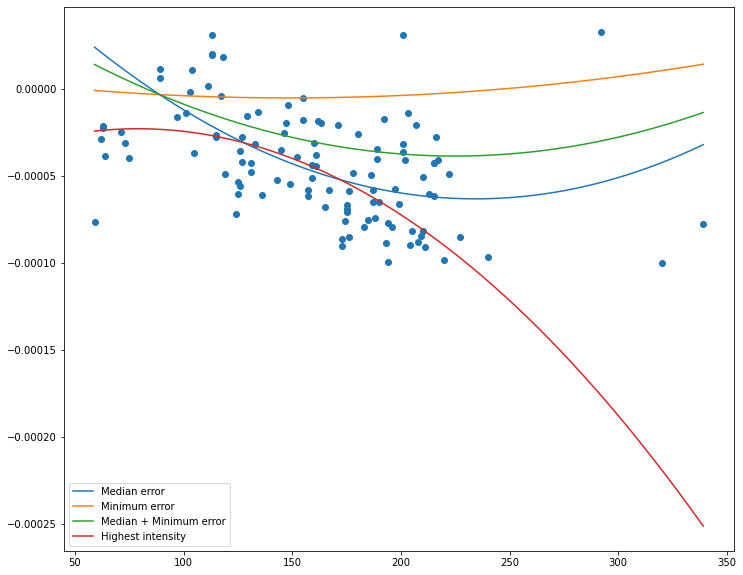

Median error:
31.61% of the prefit MSE

Minimum error:
90.94% of the prefit MSE

Median + Minimum error:
39.52% of the prefit MSE

Highest intensity:
75.38% of the prefit MSE


array([0.31613917, 0.90941434, 0.39523504, 0.75377811])

In [182]:
fitPolynomialAll(peaklists[0], 3, 1, 10, 0.6, True, True)[2]

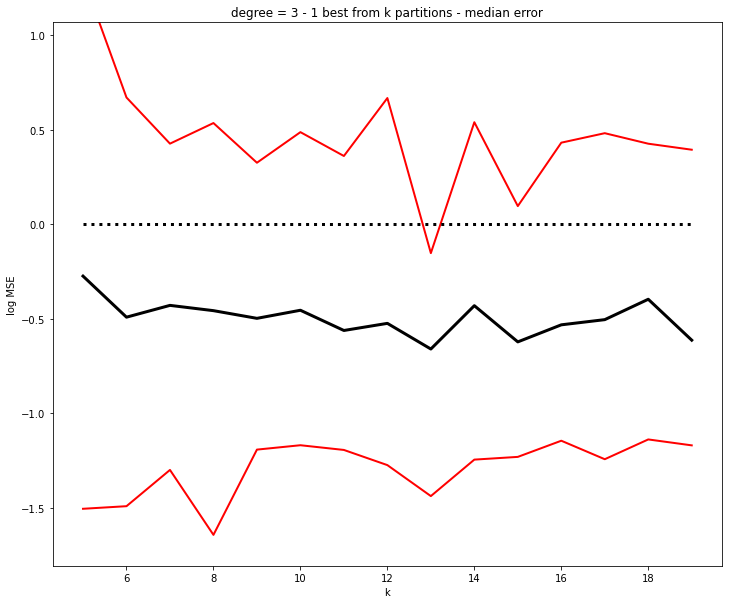

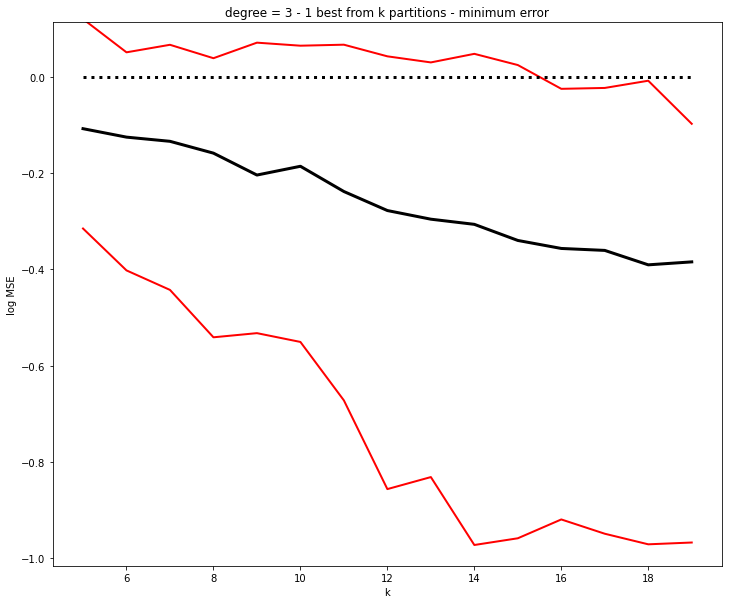

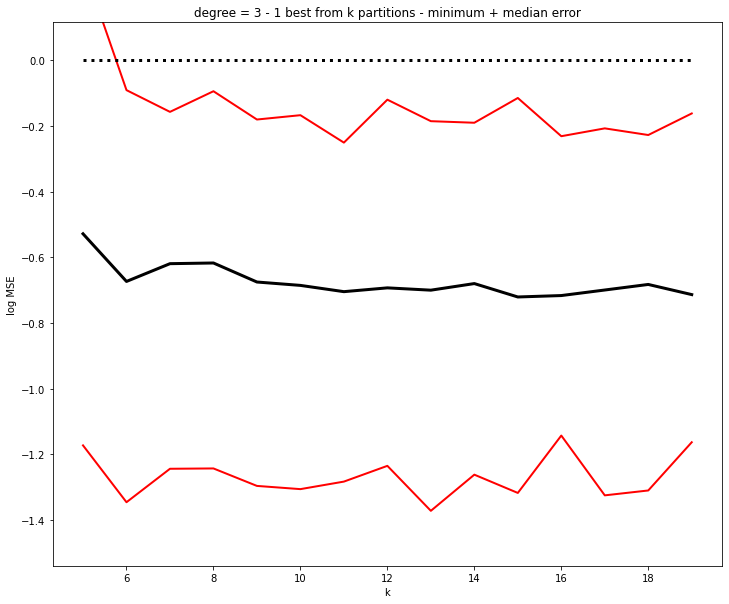

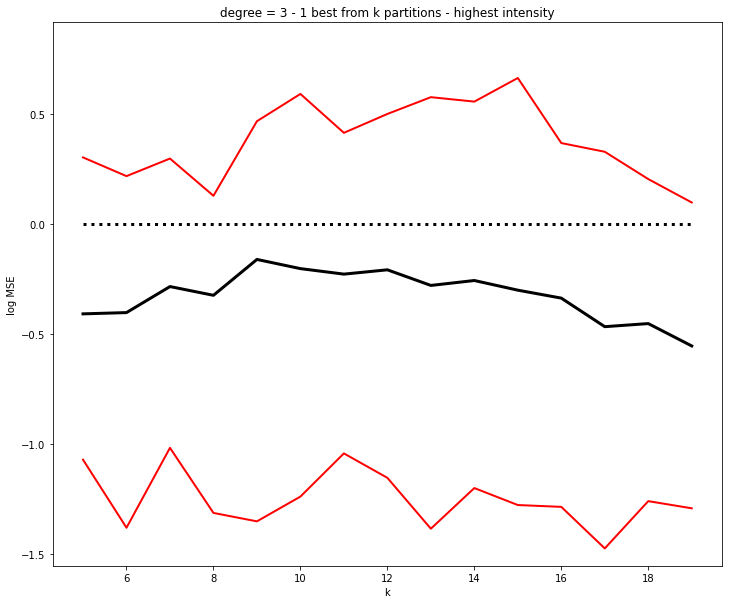

In [190]:
plotPeaklists(peaklists2, 3, False, 1, 5, 15)

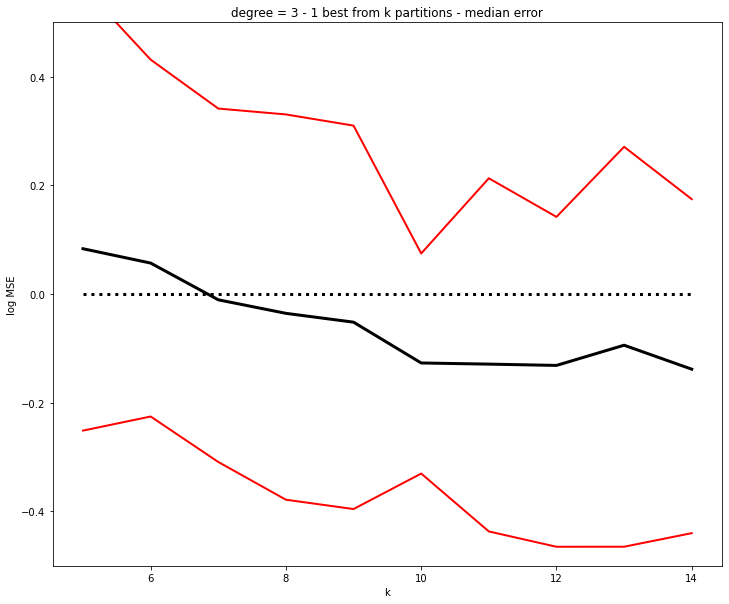

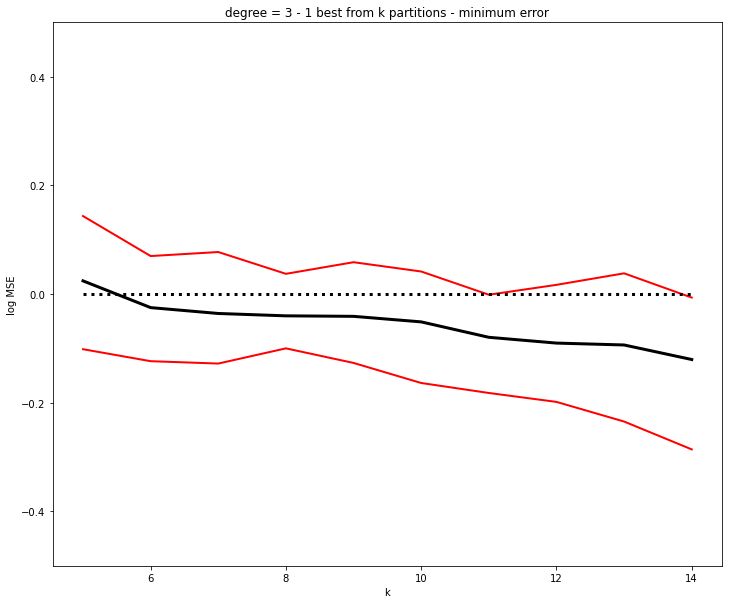

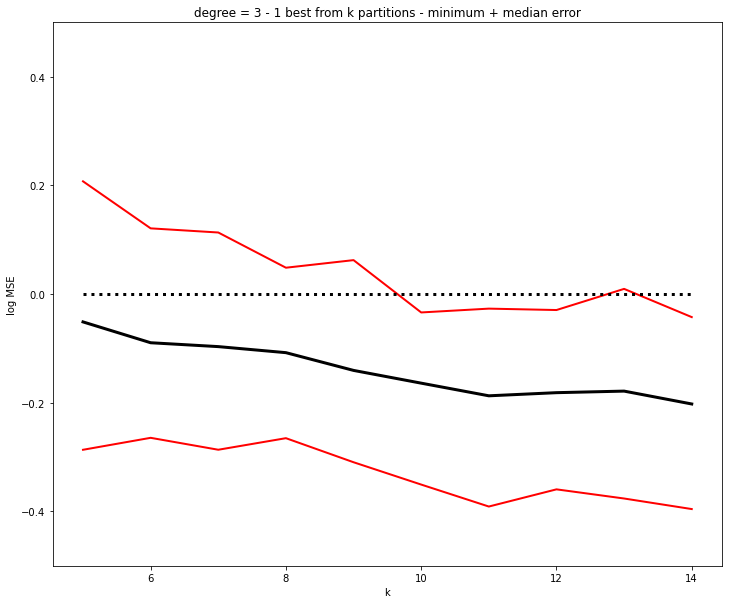

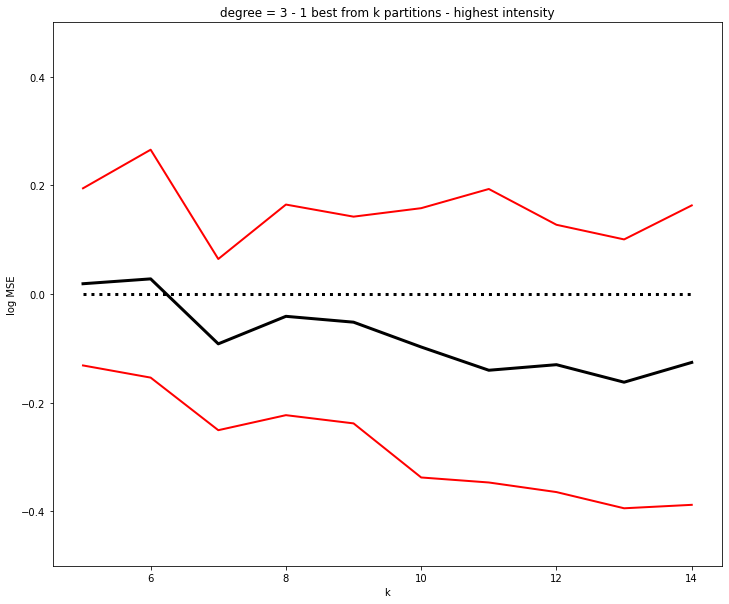

In [119]:
plotPeaklists(peaklists, 3, False, 1, 5, 10)

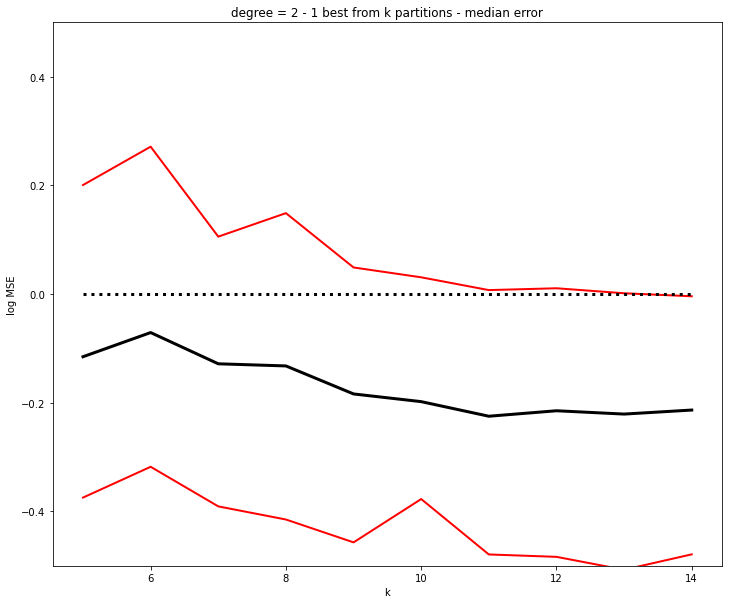

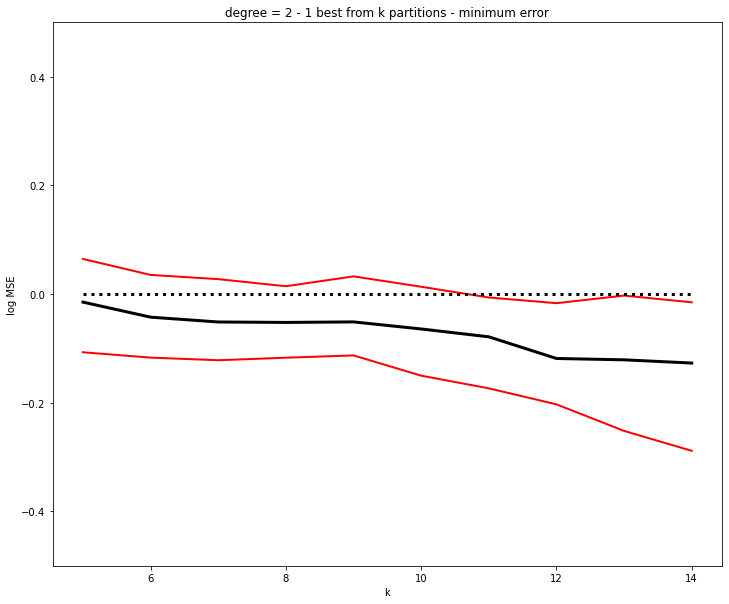

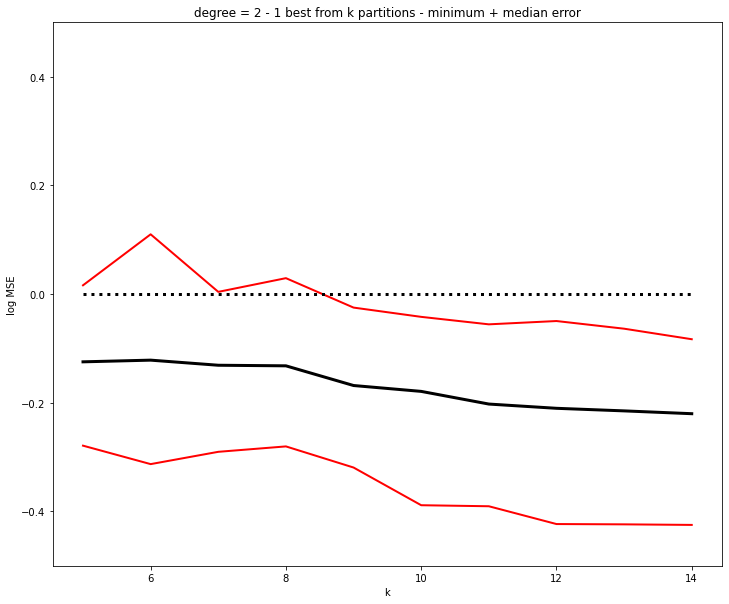

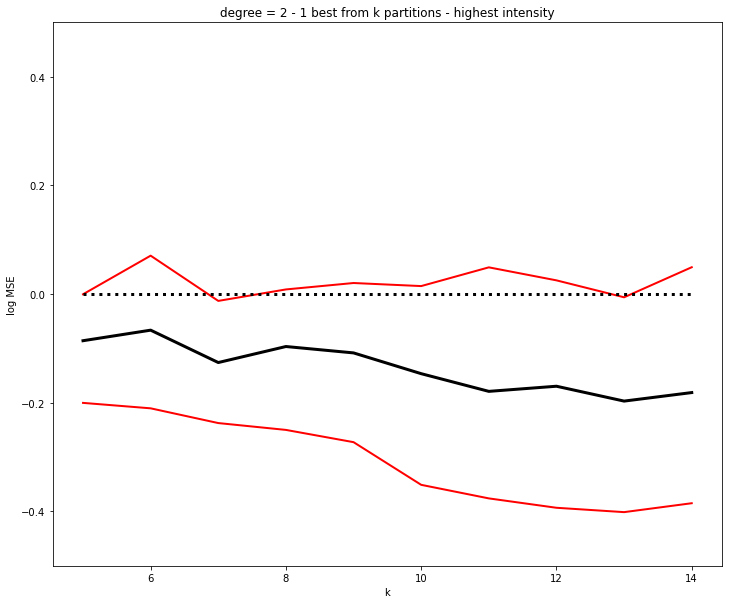

In [125]:
plotPeaklists(peaklists, 2, False, 1, 5, 10)

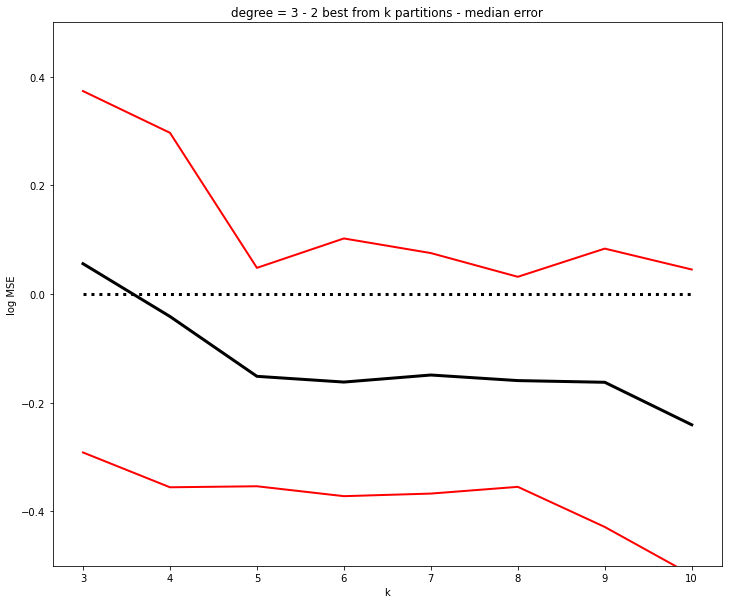

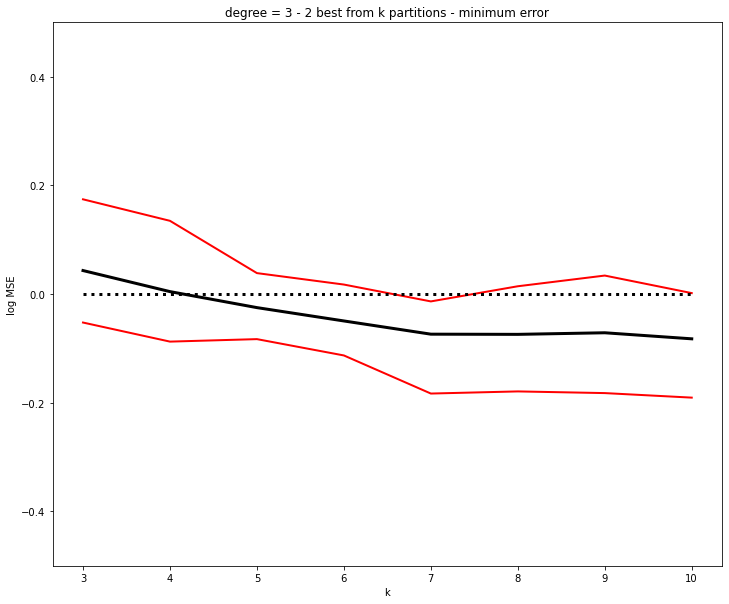

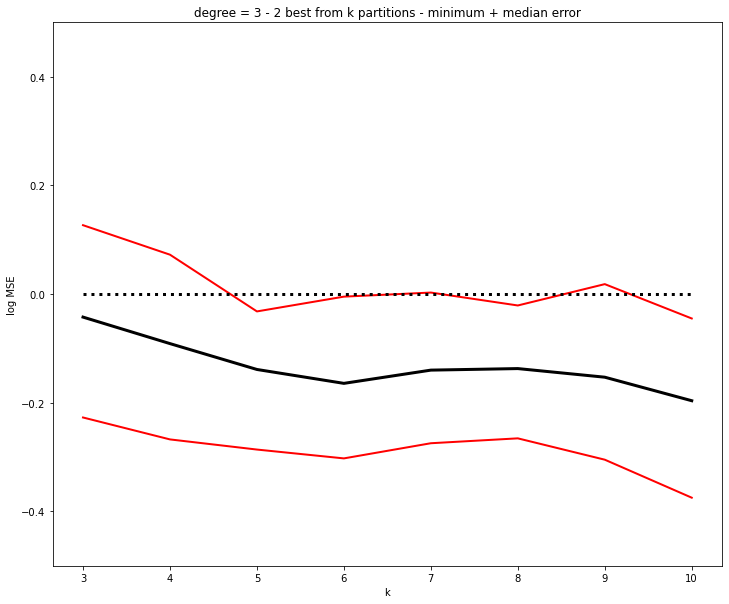

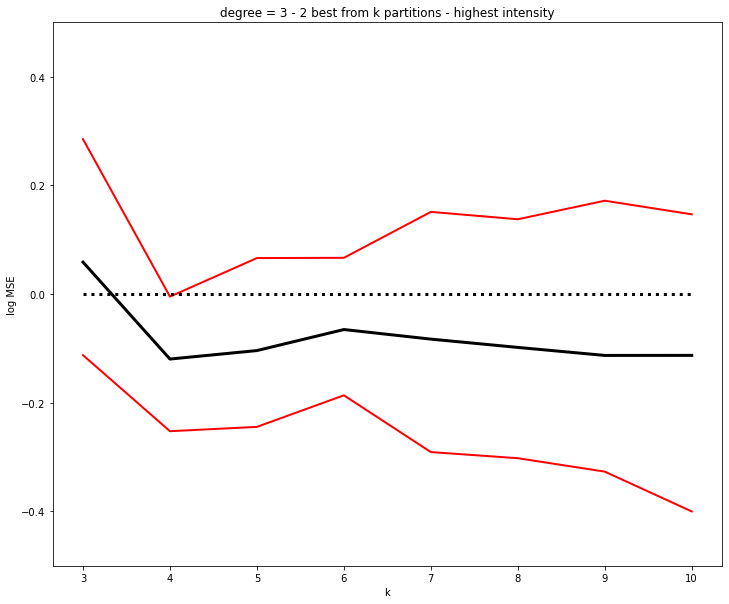

In [120]:
plotPeaklists(peaklists, 3, False, 2, 3, 8)

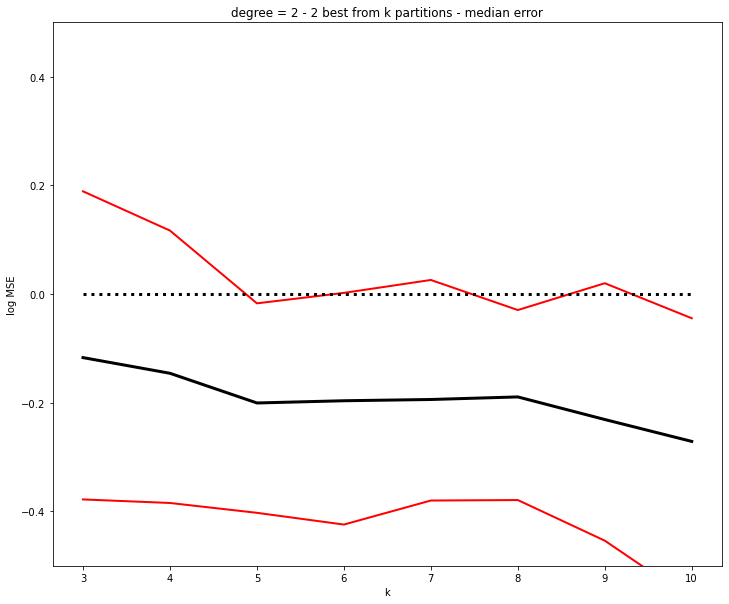

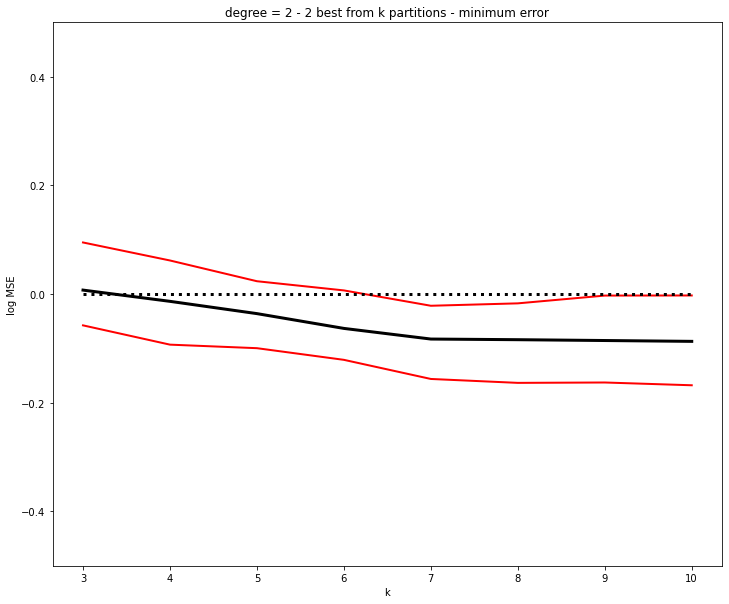

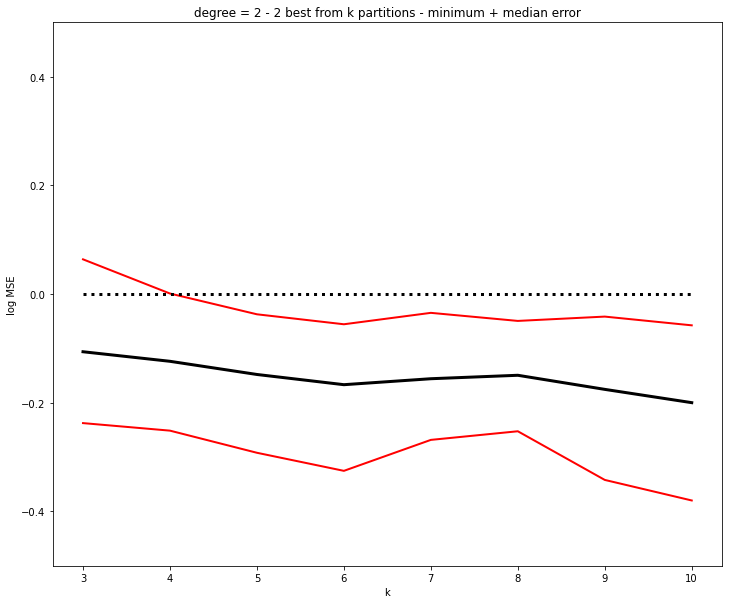

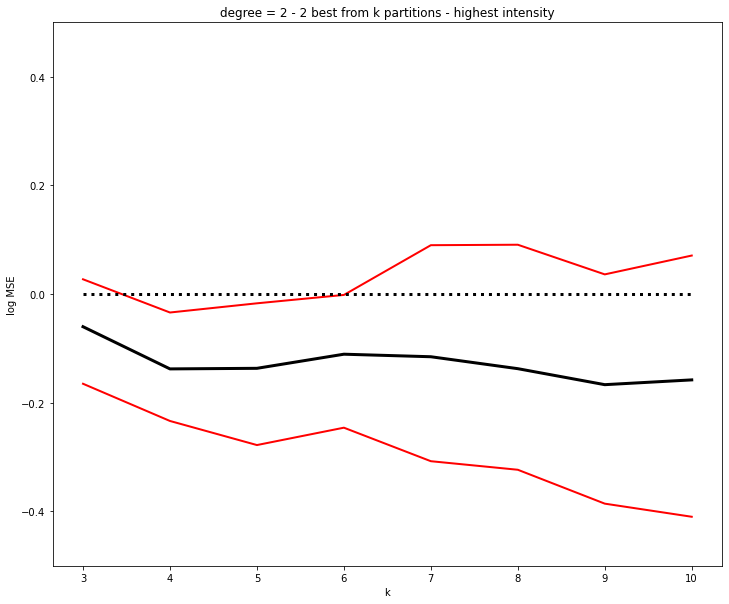

In [121]:
plotPeaklists(peaklists, 2, False, 2, 3, 8)

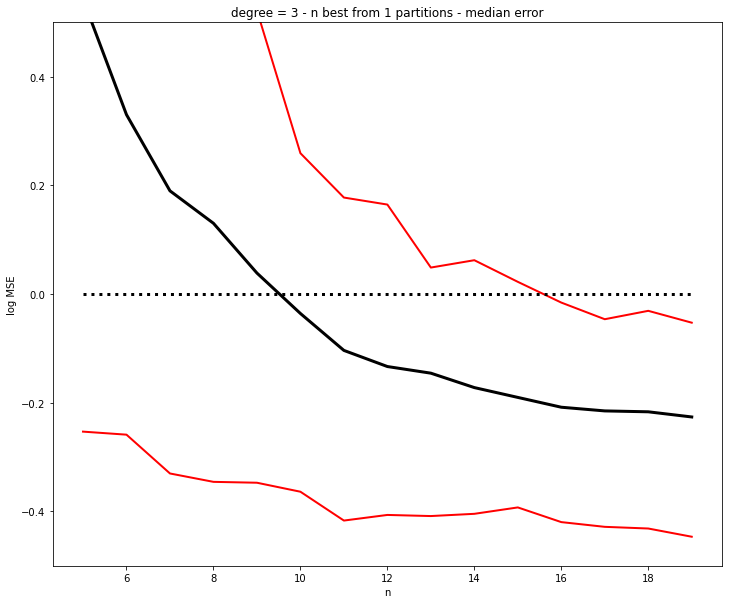

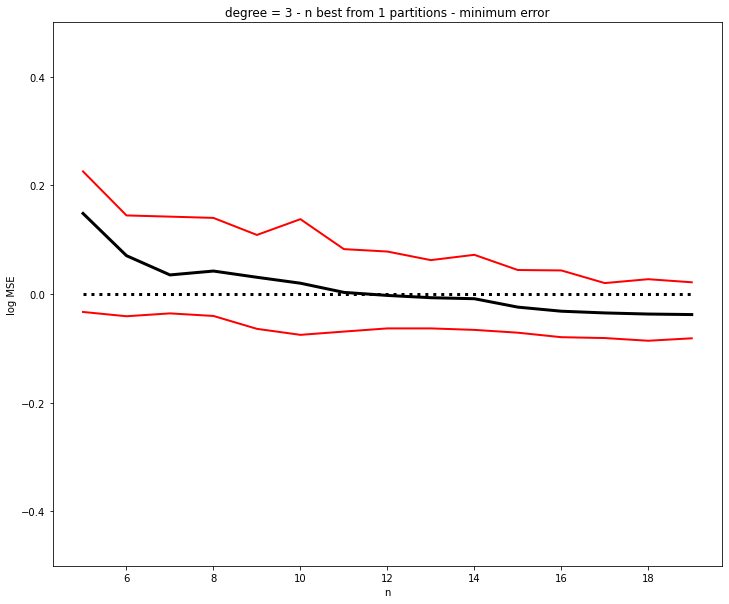

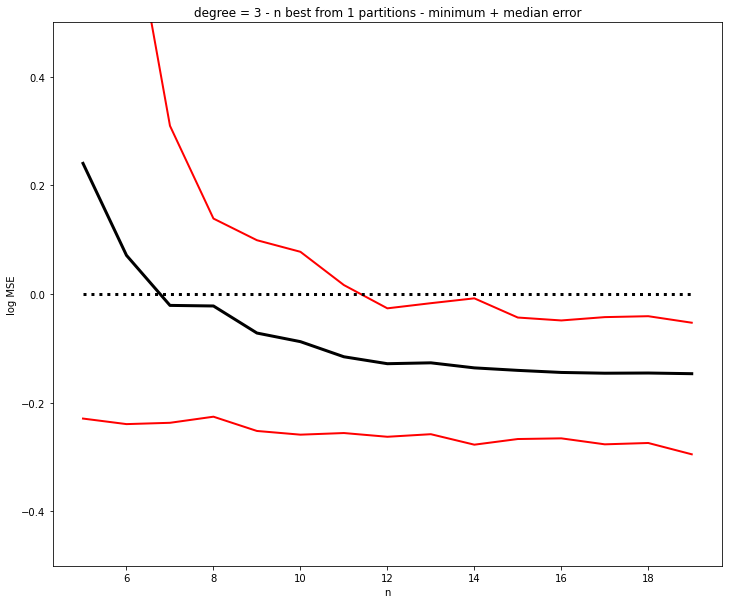

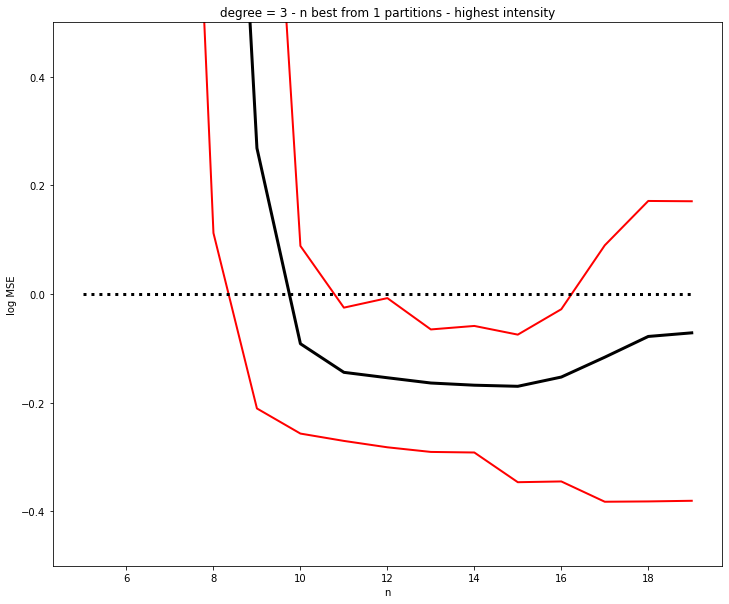

In [122]:
plotPeaklists(peaklists, 3, True, 5, 1, 15)

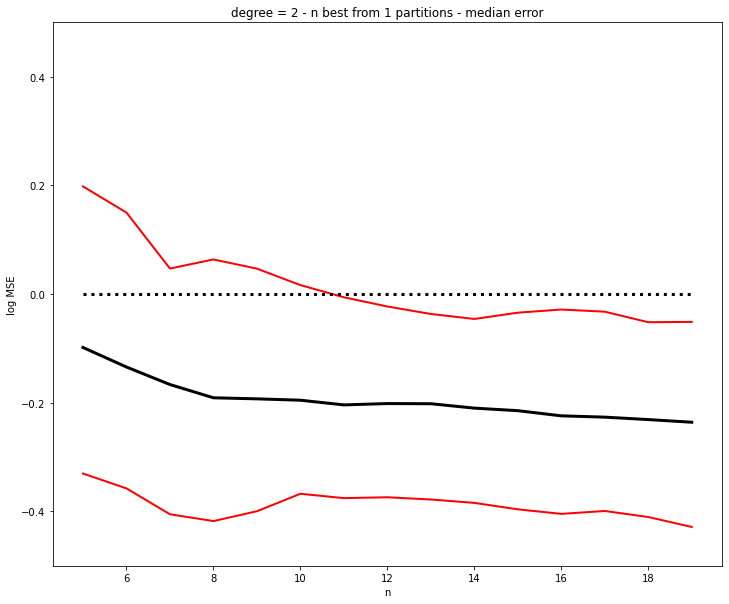

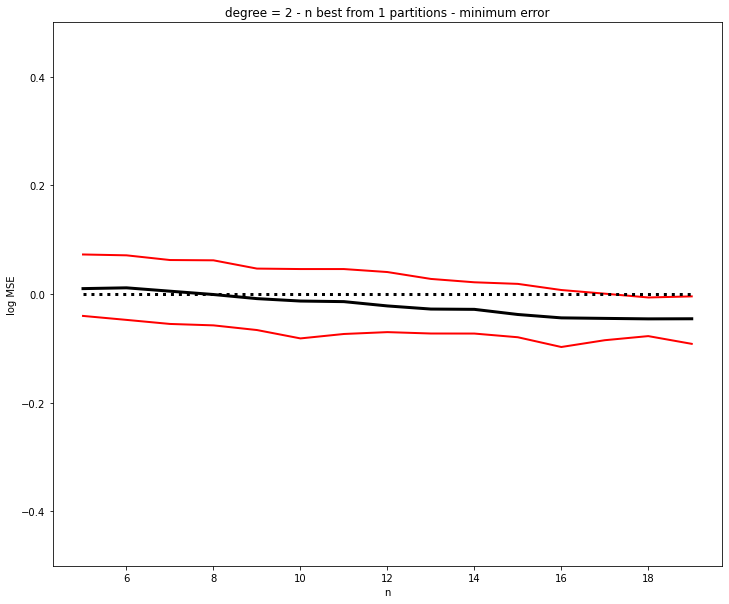

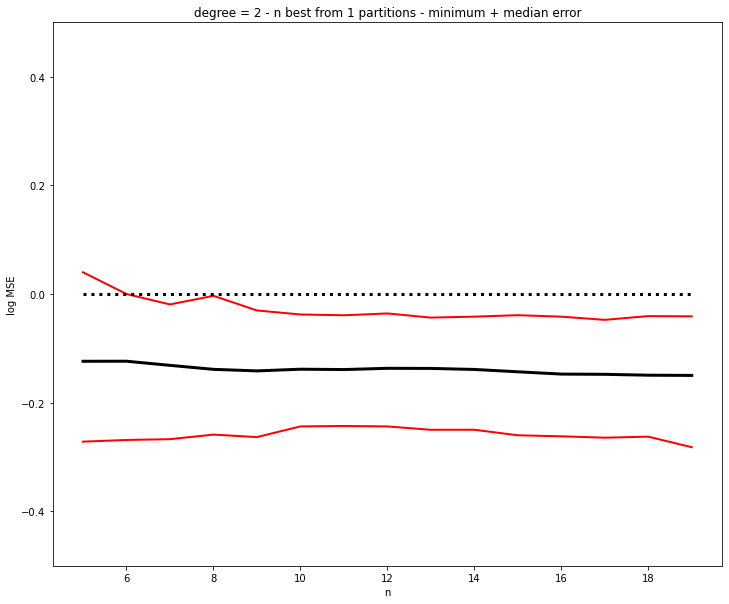

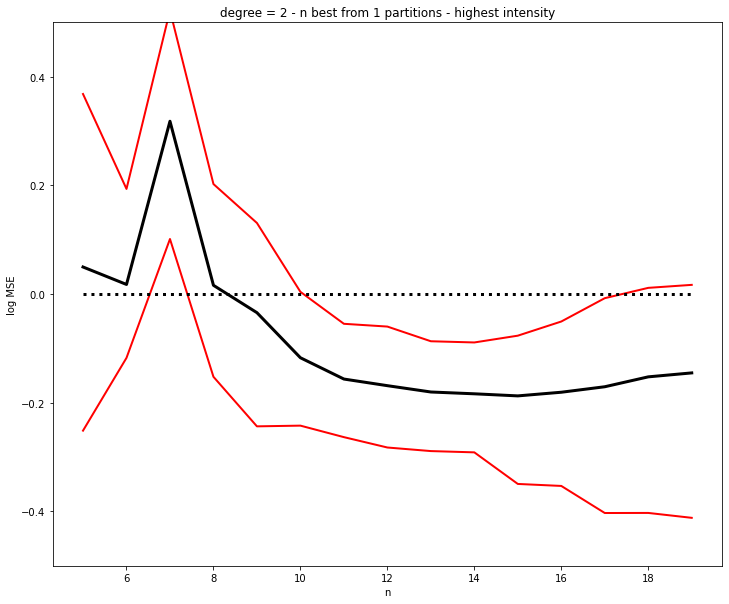

In [123]:
plotPeaklists(peaklists, 2, True, 5, 1, 15)

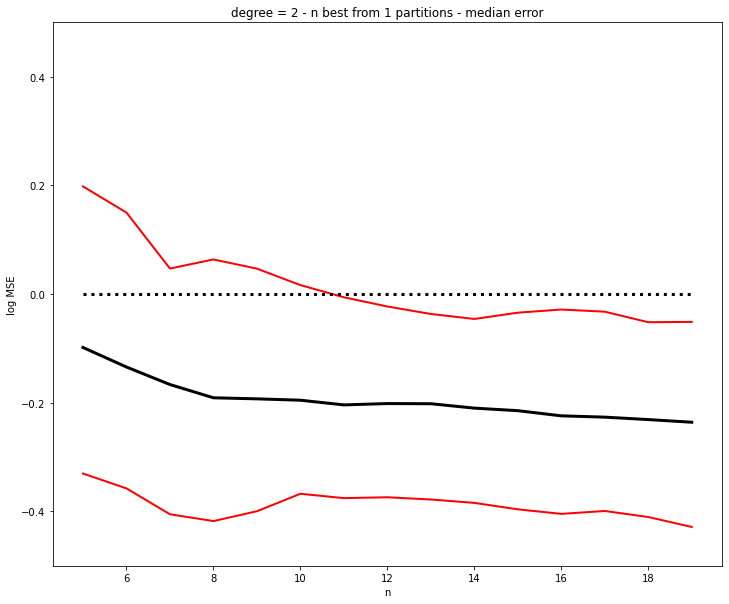

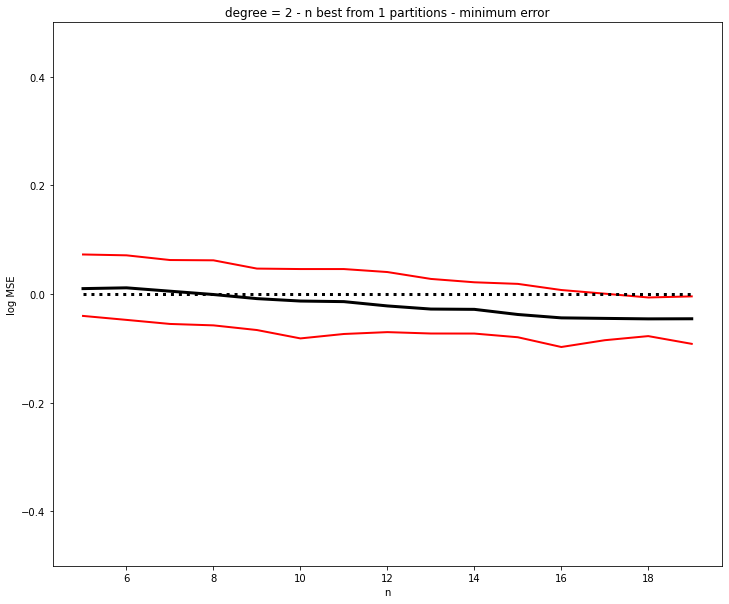

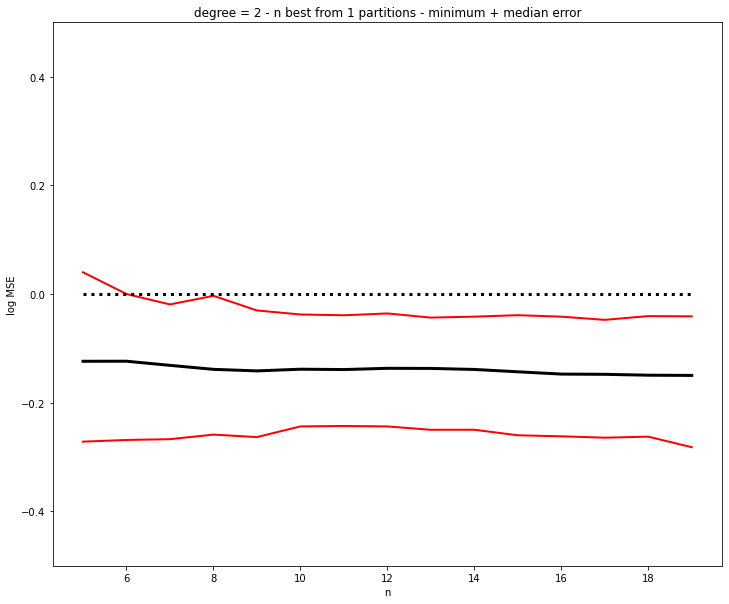

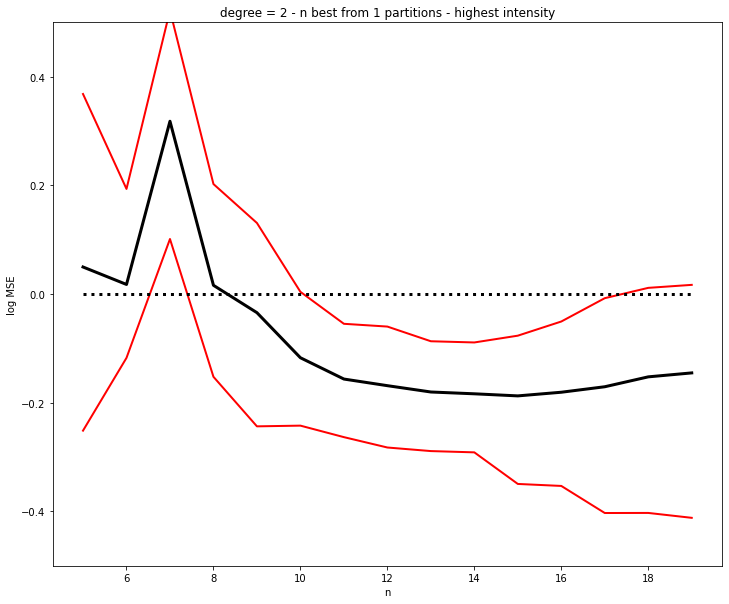

In [124]:
plotPeaklists(peaklists, 2, True, 5, 1, 15)

In [191]:
train, test = selectPeaks(peaklist, 1, 5, selectPeaksMedianError)
train2, test2 = selectPeaks(peaklist, 1, 5, selectPeaksMinimumError)

peaklist[peaklist["mz"].isin(set(test["mz"]).intersection(set(test2["mz"])))]

,formula,mz,observed,a,sigma,peak
2,O3N-,61.988366,61.988374,2.507348e+06,0.000094,5.0
4,O2O[17]N-,62.992584,62.992602,2.644745e+03,0.000096,11.0
5,O2O[18]N-,63.992613,63.992623,1.577415e+04,0.000097,12.0
10,C2HO4-,88.988032,88.988120,2.605163e+03,0.000135,15.0
16,C3H3O4-,103.003682,103.003768,8.110238e+03,0.000156,16.0
21,C2O2F3-,112.985587,112.985649,7.397827e+02,0.000171,18.0
26,C4H5O4-,117.019332,117.019400,1.934514e+03,0.000177,19.0
29,CH2O6N-,123.988760,123.988718,7.014656e+02,0.000188,20.0
32,HO6NN[15]-,125.981044,125.981036,7.785423e+03,0.000191,26.0
34,HO5O[18]N2-,126.988256,126.988262,1.145781e+04,0.000193,28.0


In [192]:
peaklists = [peaklist, peaklist2, peaklist3]
combineObservations(peaklists)

,mz,observed,observed_1,observed_2
formula,,,,
O3N-,61.988366,61.988374,61.988375,61.988376
O3N[15]-,62.985401,62.985426,62.985426,62.985425
O2O[17]N-,62.992584,62.992602,62.992598,62.992600
O2O[18]N-,63.992613,63.992623,63.992625,63.992623
C2HO4-,88.988032,88.988120,88.988109,88.988120
C3H3O4-,103.003682,103.003768,103.003761,103.003767
C2O2F3-,112.985587,112.985649,112.985675,NaN
C4H5O4-,117.019332,117.019400,117.019377,117.019398
CH2O6N-,123.988760,123.988718,123.988746,123.988731


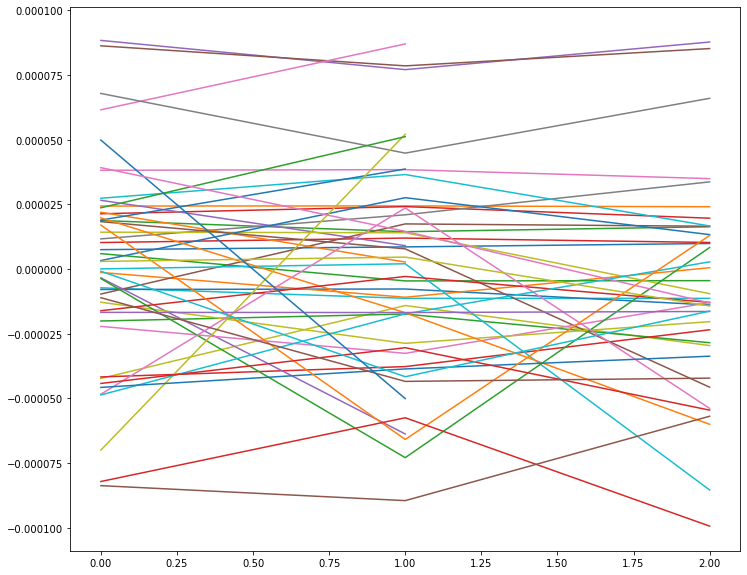

In [193]:
lists = peaklist.set_index("formula").join(peaklist2.set_index("formula"), on="formula", rsuffix='_2').join(peaklist3.set_index("formula"), on="formula", rsuffix='_3')
plt.plot(range(3), [lists["observed"]-lists["mz"], lists["observed_2"]-lists["mz"], lists["observed_3"]-lists["mz"]])
plt.show()

In [194]:
print(getLogIntensity(peaklist.iloc[0,3], peaklist.iloc[0,4]))
print(getIntensity(peaklist.iloc[0,3], peaklist.iloc[0,4]))

24.925737038087547
66851330167.3378


In [195]:
ind = findPeakIndices(data)
i = 88
peak = data[ind[i,0]:ind[i,1]+1,:]
getMeans(peak)

(array([294.04635112]), array([551.2360825]), array([0.00044596]))

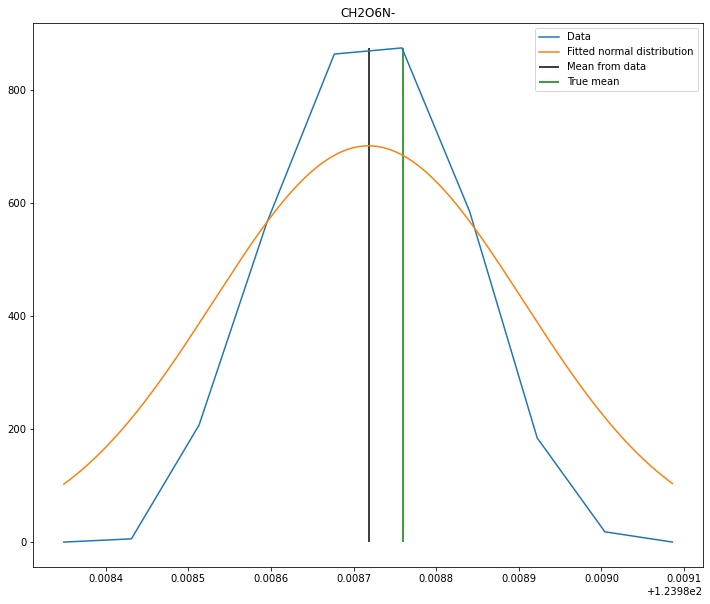

In [199]:
# Plot a peak
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

i = 8
plotPeak(i, peaklist, data1)

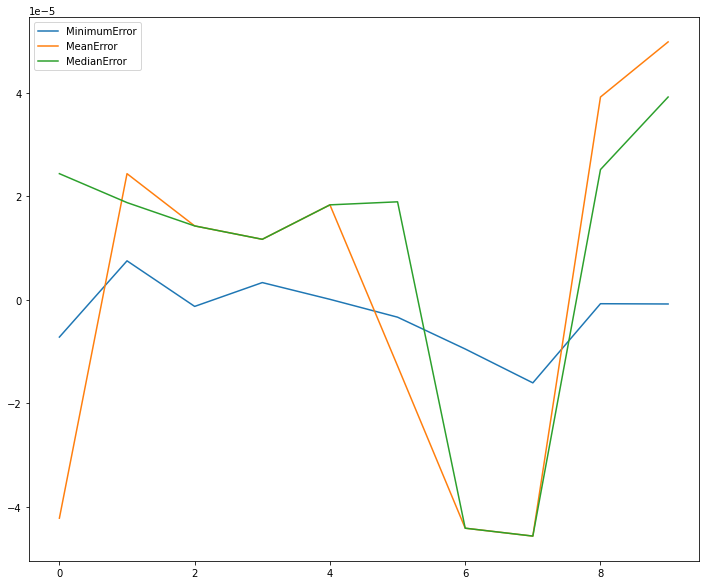

In [197]:
n = 2
k = 5

y = selectPeaks(peaklist, n, k, selectPeaksMinimumError)[0]
y = y.iloc[:,2] - y.iloc[:,1]
y2 = selectPeaks(peaklist, n, k, selectPeaksMeanError)[0]
y2 = y2.iloc[:,2] - y2.iloc[:,1]
y3 = selectPeaks(peaklist, n, k, selectPeaksMedianError)[0]
y3 = y3.iloc[:,2] - y3.iloc[:,1]
plt.plot(range(len(y)), y)
plt.plot(range(len(y2)), y2)
plt.plot(range(len(y3)), y3)
plt.legend(["MinimumError", "MeanError", "MedianError"])
plt.show()